In [1]:
import sys
import os
os.chdir("/home/jonfrey/ASL")
sys.path.append("""/home/jonfrey/ASL/src/""")
sys.path.append("""/home/jonfrey/ASL/src/pseudo_label""")

from pseudo_label.yolo import YoloHelper
from pseudo_label.deeplab import DeeplabHelper
from pseudo_label.fast_scnn import FastSCNNHelper
from visu import Visualizer

import numpy as np
import imageio

visu = Visualizer(os.getenv('HOME')+'/tmp', logger=None, epoch=0, store=False, num_classes=41)

DEVICE = 'cuda:0'
yh = YoloHelper()
dlh = DeeplabHelper(device=DEVICE)
fsh = FastSCNNHelper(device=DEVICE)

# -> visu, yh, dlh, fsh 

Using cache found in /home/jonfrey/.cache/torch/hub/ultralytics_yolov5_master

                 from  n    params  module                                  arguments                     
  0                -1  1      8800  models.common.Focus                     [3, 80, 3]                    
  1                -1  1    115520  models.common.Conv                      [80, 160, 3, 2]               
  2                -1  1    309120  models.common.C3                        [160, 160, 4]                 
  3                -1  1    461440  models.common.Conv                      [160, 320, 3, 2]              
  4                -1  1   3285760  models.common.C3                        [320, 320, 12]                
  5                -1  1   1844480  models.common.Conv                      [320, 640, 3, 2]              
  6                -1  1  13125120  models.common.C3                        [640, 640, 12]                
  7                -1  1   7375360  models.common.Conv           

Adding autoShape... 


Using cache found in /home/jonfrey/.cache/torch/hub/kazuto1011_deeplab-pytorch_master


Restoring weights: <All keys matched successfully>


In [2]:
import yaml
from pathlib import Path
import numpy as np 
from math import ceil
import torch

from utils_asl import load_yaml
from task import TaskCreator
from task import TaskCreator
from datasets_asl import get_dataset

ASL = os.path.join( str(Path.home()), "ASL" )
name = os.getenv('ENV_WORKSTATION_NAME')
env_cfg_path =os.path.join( ASL, f"cfg/env/{name}.yml")  
exp_cfg_path =os.path.join( ASL, "cfg/exp/debug.yml")
eva_cfg_path =os.path.join( ASL, "cfg/eval/eval.yml")

env = load_yaml(env_cfg_path)

use_eva = True
if use_eva:
  exp = load_yaml(eva_cfg_path)
else:
  exp = load_yaml(exp_cfg_path)

# SETUP DATALOADERS

tc = TaskCreator(**exp['task_generator'], output_size=(640,1280) )

use_tc = True
if use_tc:    
    cfgs = []
    for idx, out in enumerate(tc):
      task, eval_lists = out
      cfgs.append(  task.dataset_train_cfg )
else:
    cfgs  = [exp['dataset']]

for cfg in cfgs:
  dataset= get_dataset(
    **cfg,
    env = env,
    output_trafo = None,
  )
  dataloader = torch.utils.data.DataLoader(dataset,
    shuffle = False,
    num_workers = exp['loader']['num_workers'],
    pin_memory = exp['loader']['pin_memory'],
    batch_size = 1, 
    drop_last = True)
  break
    
# -> dataset, dataloader, exp

train_task 0 ['scene0057', 'scene0016', 'scene0006', 'scene0045', 'scene0012']
eval_task 0 ['scene0057', 'scene0016', 'scene0006', 'scene0045', 'scene0012']
eval_task 1 ['scene0072', 'scene0053', 'scene0000', 'scene0091', 'scene0054']
eval_task 2 ['scene0025', 'scene0097', 'scene0027', 'scene0002', 'scene0074']
eval_task 3 ['scene0029', 'scene0073', 'scene0017', 'scene0068', 'scene0092']
train_task 1 ['scene0072', 'scene0053', 'scene0000', 'scene0091', 'scene0054']
eval_task 0 ['scene0057', 'scene0016', 'scene0006', 'scene0045', 'scene0012']
eval_task 1 ['scene0072', 'scene0053', 'scene0000', 'scene0091', 'scene0054']
eval_task 2 ['scene0025', 'scene0097', 'scene0027', 'scene0002', 'scene0074']
eval_task 3 ['scene0029', 'scene0073', 'scene0017', 'scene0068', 'scene0092']
train_task 2 ['scene0025', 'scene0097', 'scene0027', 'scene0002', 'scene0074']
eval_task 0 ['scene0057', 'scene0016', 'scene0006', 'scene0045', 'scene0012']
eval_task 1 ['scene0072', 'scene0053', 'scene0000', 'scene009

In [3]:
dataset[0][0].shape

torch.Size([3, 640, 1280])

In [4]:
def get_max_acc(label, gt , names = ['deeplab', 'yolo', 'fastscnn', 'gt'] ):
    m = gt != -1
    acc_indi = {}
    for l,n in zip(label,names):
        correct = ( l[m] == gt[m]).sum()
        m2 = m * (l != -1)
        total = m2.sum()
        acc_indi[n] = correct/total
        
    # Optimal upper bound
    m = gt != -1
    m_correct = np.zeros( label[0].shape )
    for l,n in zip(label,names):
        m_est = l == gt
        m_correct[m_est] = 1
        
    
    acc_upper_bound = m_correct[m].sum() / m.sum()
    acc_indi['upper_bound'] = acc_upper_bound
    return acc_indi
# -> get indiviual ACC per network but also upper bound

In [5]:
from pseudo_label import *

class PseudoLabelLoaderOnline():
    def __init__(self, image_paths, mapping, h=640, w=1280, sub=10):
        self.image_paths = image_paths
        self.sub = sub
        self.H, self.W= h,w 
        self.mapping = mapping
        
    def get_flow(self, global_idx):
        flow = []
        for idx in global_idx:
            fp = self.mapping( self.image_paths[idx] )
            
            try:
                print("Flow Path", fp)
                flow.append( readFlowKITTI( fp, H=self.H ,W=self.W))
            except:
                return False, False
        flow.reverse()
        return True, flow
    
def mapping_labdata(s, sub=10):
    return s.replace("/2/",f"/2_flow_sub{sub}/")
def mapping_scannet(s, sub=10):
    return str(os.path.join( "/home/jonfrey/datasets/scannet/flow", s[s.find('scans'):])).replace('.jpg','.png').replace('color', f'flow_sub{sub}')


mapping = mapping_scannet if use_tc else mapping_labdata
pllo = PseudoLabelLoaderOnline( 
    image_paths = dataset.image_pths,
    mapping = mapping,
    sub=10)

In [6]:
def index_check_labdata(global_idx_list, global_idx_pths, sub=10): 
    assert len(global_idx_list) > 1
    for a,b in zip(global_idx_list[:-1], global_idx_list[1:]):
        a = int(global_idx_pths[a].split('/')[-1].replace("undistorted_frame","")[:-4])
        b = int(global_idx_pths[b].split('/')[-1].replace("undistorted_frame","")[:-4])
        if a + sub != b:
            return False
    return True

In [7]:
from torchvision.utils import make_grid
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

import copy
import torch
import cv2
import numpy as np
import imageio
import os

import matplotlib.pyplot as plt
"""
TODO:
- Depth
- BoundingBox Predicitons
"""
from torch.nn.functional import one_hot
class PseudoLabelGenerator():
    def __init__(self, base_path, sub=10, confidence='equal', 
            flow_mode='sequential', H=640, W=1280, 
            nc=40, refine_superpixel=True,
            get_depth_superpixel=False,window_size=10,
            visu=None, pre_fusion_function=None, visu_active=True, cfg_loader={}):
        """  
        confidence:
          'equal': perfect optical flow -> all project labels are equally good
          'linear': linear rate -> per frame
          'exponential': exponential rate -> per frame 
        flow_mode:
          'sequential': #-> 0->1, 1->2, 2->3
          'target': 0->3 1->3 2->3
        """
        self._visu_active = visu_active
        self._sub = sub
        self._flow_mode = flow_mode #'sequential' #-> 0->1, 1->2, 2->3 # 'target' 0->3 1->3 2->3
        self._H,self._W = H,W
        self._confidence= confidence # equal, linear, exponential
        self._nc = nc
        self._refine_superpixel = refine_superpixel
        self._get_depth_superpixel = get_depth_superpixel
        self._window_size = window_size
        self._pll = PseudoLabelLoader(base_path = base_path, window_size=window_size, sub=10, h=H,w=W, **cfg_loader )
        self._ignore_depth = cfg_loader.get("ignore_depth",False)

        # Passed externally
        self._visu = visu
        self._pre_fusion_function = pre_fusion_function
    def __len__(self):
      return self._pll.length

    def get_gt_label(self, index):
        seg, depth, flow, paths = self._pll[index] 
        return seg[0][1]
    
    def get_img(self, index):
        return self._pll.getImage(index)
    
    def get_depth(self, index):
        seg, depth, flow, paths = self._pll[index]
        return depth[0]
    
    def calculate_label(self, index=None, seg=[],flow=[], image= None ):
        if not index is None:
            seg_forwarded= self._forward_index(index, self._pre_fusion_function) #return H,W,C
        else:
            seg_forwarded = self._forward_index(index, seg, flow, self._pre_fusion_function)
        
        if self._visu_active:
            self._visu_seg_forwarded(seg_forwarded)

        # -1 39 -> 0 -> 40 We assume that the network is also able to predict the invalid class
        # In reality this is not the case but this way we can use the ground truth labels for testing
        
        if seg_forwarded[0].shape[2] == 1:
            for i in range(len( seg_forwarded) ):
                seg_forwarded[i] += 1
                seg_forwarded[i][seg_forwarded[i]>40] = 40
        confidence_values_list = self._get_confidence_values(seq_length= len(seg_forwarded))
        if seg_forwarded[0].shape[2] == 1:
            
            one_hot_acc = np.zeros( (*seg_forwarded[0].shape, self._nc+1), dtype=np.float32) # H,W,C
            
            for conf, seg in zip(confidence_values_list, seg_forwarded):    
                one_hot_acc += (np.eye(self._nc+1)[seg.astype(np.int32)]).astype(np.float32) * conf
            one_hot_acc = one_hot_acc[:,:,0,:]
            invalid_labels = np.sum( one_hot_acc[:,:,1:],axis=2 ) == 0
            
        
        label = np.argmax( one_hot_acc[:,:,1:], axis=2 )
        label[ invalid_labels ] = -1 
        
#         if self._visu_active:
#             print("Aggregated Label")
#             self._visu.plot_segmentation(seg= label+1, jupyter=True)

#         if self._refine_superpixel:
#             if image is None:
#                 img = self._pll.getImage(index).astype(np.float32)/256
#             else:
#                 img = image
                
#             label_super, img, segments = self._superpixel_label(img, label)
#             if self._visu_active:
#                 print("Label Superpixel")
#                 self._visu.plot_segmentation(seg= label_super + 1, jupyter=True)  
#                 self._visu.plot_image(img=img, jupyter=True)  
#                 self._visu_superpixels(img, segments)
#             label = label_super
#         print( "Time rest", time.time()-st)
#         if self._get_depth_superpixel:
#             self._superpixel_depth(depth_forwarded[-1], label)
        return label, (seg_forwarded[-1]-1).astype(np.int32)
    
    def _get_confidence_values( self, seq_length ):
        if self._confidence == 'equal':
            return [float( 1/seq_length)] * seq_length 

        if self._confidence == 'linear':
            ret = []
            lin_rate = 0.1
            s = 0
            for i in range(seq_length):
                res = 1 - lin_rate* (seq_length-i)
                if res < 0: 
                    res = 0
                s += res

                ret.append(res)
            return [r/s for r in ret]

        elif self._confidence == 'exponential':
            ret = []
            exp_rate = 0.8
            s = 0
            for i in range(seq_length):
                res = exp_rate**(seq_length-i)
                if res < 0: 
                    res = 0
                s += res
                ret.append(res)
            return [r/s for r in ret]


    def _forward_index(self, index=None, seg=[],flow=[] ,pre_fusion_function=None ):
        """
        seg[0] , C,H,W
        
        pre_fusion_function should be used to integrate the depth measurments 
        to the semseg before forward projection !

        seg_forwarded[0] -> oldest_frame
        seg_forwarded[len(seg_forwarded)] -> latest_frame not forwarded

        """
        
        if not index is None:
            if pre_fusion_function is None:
                seg, _, flow, _ = self._pll[index]
            else:
                seg, _, flow, _ = pre_fusion_function( self._pll[index] )
        
        if len( seg[0].shape ) == 3 and seg[0].shape[0] != 1:
            soft = True
        else:
            soft = False
            
        assert self._flow_mode == 'sequential'
        seg_forwarded = []
        
        for j in range(len( seg )):
            seg[j] = np.moveaxis( seg[j], [0,1,2], [2,0,1] ) #C,H,W -> H,W,C
        
        for i in range(0,len(seg)-1):
            i = len(seg)-1-i
            seg_forwarded.append( seg[i].astype(np.float32) )

            
            # start at oldest frame
            if i != 0:
                f = flow[i][0]
            else:
                f = np.zeros(flow[i][0].shape, dtype=np.float32)
            
            h_, w_ = np.mgrid[0:self._H, 0:self._W].astype(np.float32)
            h_ -= f[:,:,1]
            w_ -= f[:,:,0]

            j = 0
            for s in seg_forwarded : #  seg_forwarded, depth_forwarded
                if soft:
                    s = cv2.remap( s, w_, h_, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
                else:
                    s = cv2.remap( s[None], w_, h_, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=-1)[None]
                seg_forwarded[j] = s
                
                j += 1
    
        if not soft:
            for i in range(len( seg_forwarded) ):
                seg_forwarded[i] = np.moveaxis(  seg_forwarded[i] , [0,1,2], [2,0,1] )
        seg_forwarded.append( seg[0] )
        return seg_forwarded # H,W,C


    def _visu_seg_forwarded(self, seg):
        s = int( len(seg) ** 0.5 )
        ba = torch.zeros( (int(s*s),3, *seg[0].shape), dtype= torch.float32 )
        for i in range( int(s*s) ) :
            ba[i,:] = torch.from_numpy( seg[-(i+1)] )[None,:,:].repeat(3,1,1)
        grid_ba = make_grid( ba ,nrow = s ,padding = 2,
          scale_each = False, pad_value = -1)[0]
        self._visu.plot_segmentation(seg= grid_ba +1 , jupyter=True)

    def _superpixel_label(self, img, label, segments=250):
        assert segments < 256 #I think slic fails if segments > 256 given that a 8bit uint is returend!

        segments = slic(img, n_segments = segments, sigma = 5, start_label=0)
        # show the output of SLIC
        out_label = copy.copy(label)
        for i in range(0,segments.max()):
            m1 = segments == i
            m = m1 * ( label != -1 )
            unique_val, unique_counts = np.unique( label [m], return_counts=True)
            # fill a segment preferable not with invalid !
            if unique_counts.shape[0] == 0:
                val = -1
            else:
                ma = unique_counts == unique_counts.max()
                while ma.sum() != 1:
                    ma[np.random.randint(0,ma.shape[0])] = False
                val = unique_val[ma]
            out_label[m1] = val 

        return out_label, img, segments
    
    def _visu_superpixels(self, img, segments):
        import matplotlib.pyplot as plt
        from skimage.segmentation import mark_boundaries
        fig = plt.figure("Superpixels -- segments" )
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(mark_boundaries(img, segments))
        plt.axis("off")
        plt.show()

# plg_ws_2 = PseudoLabelGenerator(base_path='/home/jonfrey/results/scannet_pseudo_label/scannet', 
#                            visu=visu,
#                            window_size=window_size_2,
#                           cfg_loader = {"ignore_depth": True},
#                           visu_active=plot,
#                           refine_superpixel=False)
# pseudo_2, _ = plg_ws_2.calculate_label(
#                         index=None, 
#                         seg= seg[:window_size_2], 
#                         flow= flow_list[:window_size_2])

In [8]:
from pseudo_label import readSegmentation
import time
from torchvision import transforms as tf
import copy
# from torch import one_hot_acc
st = time.time()
counts = 0
counts_flow = 0
length = len(dataloader)
globale_idx_to_image_path = dataset.image_pths

segmentation_list_fastscnn = []
global_idx_list = []

plot = False
# PARAMS LABEL GENERATION
weights = [2,0.5,1]
weights2 = [1,0.5,1]
window_size_2 = 3
window_size = 6

sub = 10

from PIL import ImageDraw, ImageFont, Image


acc_dict = {}

plg = PseudoLabelGenerator(base_path='/home/jonfrey/results/scannet_pseudo_label/scannet', 
                           visu=visu,
                           window_size=window_size,
                          cfg_loader = {"ignore_depth": True},
                          visu_active=plot,
                          refine_superpixel=False)

plg_linear_decay = PseudoLabelGenerator(base_path='/home/jonfrey/results/scannet_pseudo_label/scannet', 
                           visu=visu,
                           window_size=window_size,
                           cfg_loader = {"ignore_depth": True},
                           visu_active=plot,
                           confidence = 'linear',
                           refine_superpixel=False)


plg_ws_2 = PseudoLabelGenerator(base_path='/home/jonfrey/results/scannet_pseudo_label/scannet', 
                           visu=visu,
                           window_size=window_size_2,
                          cfg_loader = {"ignore_depth": True},
                          visu_active=plot,
                          refine_superpixel=False)

plg_super = PseudoLabelGenerator(base_path='/home/jonfrey/results/scannet_pseudo_label/scannet', 
                           visu=visu,
                           window_size=window_size,
                          cfg_loader = {"ignore_depth": True},
                          visu_active=plot,
                          refine_superpixel=True)

def plot_pseudo_labes( res, jupyter = False, label=False, save=True, out_pth =""):
    key_list = list(res.keys())
    s = int( len( key_list ) ** 0.5 )
    if len( key_list ) - s*s != 0:
        s +=1
    ba = torch.zeros( (int(s*s),3, *res[key_list[0]].shape), dtype= torch.float32 )
    for i in range( len( key_list ) ):
        k = key_list[i]
        if k.find("img") == -1:
            img = visu.plot_segmentation( seg=res[k]+1 )
        else:
            img = res[k]
        img = Image.fromarray(img)
        
        if label:
            img = img.convert("RGBA")
            d = ImageDraw.Draw(img)
            fnt = ImageFont.truetype("/usr/share/fonts/truetype/ttf-dejavu/DejaVuSansMono-Bold.ttf", 50)   
            d.rectangle(((550, 500), (1400, 600)), fill=(254,10,10))
            d.text((600,530), k , font=fnt, fill=(254,254,254,254))
            img =  img.convert("RGB")
        if save:
            out_pth = out_pth.replace("/2/", f"/2_{k}/")
            Path(out_pth).parent.mkdir(parents=True, exist_ok=True)
            print( out_pth)
            img.save( out_pth )
        
        img = np.array( img )
        ba[i,:] = torch.from_numpy( img[:,:,:3] ).permute(2,0,1)
    
    grid_ba = make_grid( ba ,nrow = s ,padding = 2,
      scale_each = False, pad_value = 0)
    return visu.plot_image(img = grid_ba, jupyter= jupyter)


down = tf.Resize((320,640))
up = tf.Resize((640,1280))
label_list = []

def print_acc(acc_dict, counts, counts_flow):
    avg = {}
    for k in acc_dict.keys():
        if k.find('flow') != -1:
            avg  = acc_dict[k] / counts_flow
        else:
            avg = acc_dict[k] / counts
    
        print(k ,": ", avg)

for j, batch in enumerate( dataloader ):
    # START EVALUATION  
    images = batch[0]
    target = batch[1]
    ori_img = batch[2]
    replayed = batch[3]
    BS = images.shape[0]
    global_idx = batch[4] 
    images *= 255
    images = images.permute(0,2,3,1).numpy().astype(np.uint8)
    
    
    pri = False
    
    
    for b in range( images.shape[0] ):
        # EVALUATE SEMANTIC SEGMENTATION NETWORKS
        label = {}
        st_ = time.time()
        prob_dl = dlh.get_label_prob( images[b] )
        prob_yolo = yh.get_label_prob( images[b] )
        
        inp = down(torch.from_numpy( images[b]).permute(2,0,1)).permute(1,2,0).numpy()
        prob_fastscnn = fsh.get_label_prob( inp )
        prob_fastscnn = up ( torch.from_numpy( prob_fastscnn[None]) )[0].numpy()
        
        label['dl'] = np.argmax( prob_dl[:] , axis=0)-1
        label['yolo'] = np.argmax( prob_yolo[:] , axis=0)-1
        label['fastscnn'] = np.argmax( prob_fastscnn[:] , axis=0)-1
        
        prob_sum = prob_dl + prob_yolo + prob_fastscnn
        label['sum'] = np.argmax( prob_sum[1:] , axis=0)
        
        
        prob_weighted_sum = weights[0] * prob_dl + weights[1] * prob_yolo + weights[2] * prob_fastscnn
        label['weighted_sum'] = np.argmax( prob_weighted_sum[1:] , axis=0)
        
        
        prob_weighted_sum2 = weights2[0] * prob_dl + weights2[1] * prob_yolo + weights2[2] * prob_fastscnn
        label['weighted_sum2'] = np.argmax( prob_weighted_sum2[1:] , axis=0)
        print("Time to get predictions", time.time()-st_ )
        
        # RINGBUFFER THE PREDICTIONS
        label_list.append( copy.deepcopy( label) )
        global_idx_list.append(int( global_idx[b] ))
        if len(label_list) > window_size:
            label_list = label_list[-window_size:]
            global_idx_list = global_idx_list[-window_size:]
            
            # GET THE FLOW BETWEEN THE FRAMES
            suc, flow_list = pllo.get_flow( global_idx = global_idx_list)
            
            # CHECK IF THE GLOBAL IDX LIST ALIGNS
            
            suc *= index_check_labdata(global_idx_list= global_idx_list, 
                                       global_idx_pths=globale_idx_to_image_path, 
                                       sub=10)    
                
            # CREATE PSEUDO LABEL
            if suc:
                st_ = time.time()
                for k in list( ["weighted_sum",'dl',"fastscnn"] ): 
                    seg = [ s[k][None] for s in label_list ]
                    # seg[0] 1,H,W
                    seg.reverse()
                    
                    pseudo_label, _ = plg.calculate_label(
                        index=None, 
                        seg= copy.deepcopy(seg), 
                        flow=  copy.deepcopy(flow_list) )
                    label[k+'_normal_flow'] = pseudo_label
                    
                    pseudo_2, _ = plg_ws_2.calculate_label(
                        index=None, 
                        seg= copy.deepcopy(seg[:window_size_2]), 
                        flow= copy.deepcopy(flow_list[:window_size_2]))
                    
                    label[k+'_w2_flow'] = pseudo_2
                    
                    pseudo_linear, _ = plg_ws_2.calculate_label(
                        index=None, 
                        seg= seg, 
                        flow= flow_list)
                    
                    label[k+'_pseudo_linear_flow'] = pseudo_linear
                    
                print("time to create all pseudo labels", time.time()-st_ )   
                pri =True
                counts_flow += 1


        # EVALUATE ALL LABELS
        ret = get_max_acc(
                label = list( label.values()) , 
                gt=target[b].numpy(), 
                names= list( label.keys()))
        print("Return values" , ret)

        for k in ret.keys():
            if k in acc_dict:
                acc_dict[k] += ret[k]
            else:
                acc_dict[k] = ret[k]
        counts += 1
    
    print_acc(acc_dict,counts,counts_flow)
    # LOGGING
#     if (j % 1) == 0 and j != 0:
#         print_acc(acc_dict)
        
#         mini =int((time.time()-st)/60)
#         mini_left = int((time.time()-st)/j*(length-j)/60)
#         print(f'{j}/{length} Total time elapsed: {mini}min; Projected finish in {mini_left}min')
#         plot = label
#         plot['img'] = images[b]
#         plot['gt'] = target[b].numpy()  
#         try:
#             plot['img_flow'] = visu.plot_flow(flow= flow_list[1][0])
#         except:
#             print("no flow")
        
#         out_pth = globale_idx_to_image_path[ global_idx_list[-1] ]    
#         res = plot_pseudo_labes( plot, jupyter = False, label=False, save=True, out_pth = out_pth )
#         img = Image.fromarray(res)
#         out_pth = globale_idx_to_image_path[ global_idx_list[-1] ].replace("/2/", "/2_all/")   
#         Path(out_pth).parent.mkdir(parents=True, exist_ok=True)
#         img.save( out_pth )

/home/jonfrey/miniconda3/envs/track4/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Time to get predictions 10.098583936691284
Return values {'dl': 0.8498884829276167, 'yolo': 0.0, 'fastscnn': 0.5741649670095328, 'sum': 0.7507226599756424, 'weighted_sum': 0.8385851515996341, 'weighted_sum2': 0.7649447550292733, 'upper_bound': 0.8502846620005576}
dl :  0.8498884829276167
yolo :  0.0
fastscnn :  0.5741649670095328
sum :  0.7507226599756424
weighted_sum :  0.8385851515996341
weighted_sum2 :  0.7649447550292733
upper_bound :  0.8502846620005576
Time to get predictions 10.554524660110474
Return values {'dl': 0.8598043423239026, 'yolo': 0.0, 'fastscnn': 0.5826862153163694, 'sum': 0.7187124399497712, 'weighted_sum': 0.8478377026790747, 'weighted_sum2': 0.7343337527220529, 'upper_bound': 0.8601919406448805}
dl :  0.8548464126257596
yolo :  0.0
fastscnn :  0.5784255911629511
sum :  0.7347175499627068
weighted_sum :  0.8432114271393544
weighted_sum2 :  0.7496392538756631
upper_bound :  0.855238301322719
Time to get predictions 10.463908433914185
Return values {'dl': 0.839293030

time to create all pseudo labels 5.9663331508636475
Return values {'dl': 0.711759222828603, 'yolo': 0.0, 'fastscnn': 0.07195508981664323, 'sum': 0.47937375961434636, 'weighted_sum': 0.68213484721924, 'weighted_sum2': 0.541392111426504, 'weighted_sum_normal_flow': 0.68213484721924, 'weighted_sum_w2_flow': 0.68213484721924, 'weighted_sum_pseudo_linear_flow': 0.68213484721924, 'dl_normal_flow': 0.711759222828603, 'dl_w2_flow': 0.711759222828603, 'dl_pseudo_linear_flow': 0.711759222828603, 'fastscnn_normal_flow': 0.07195508981664323, 'fastscnn_w2_flow': 0.07195508981664323, 'fastscnn_pseudo_linear_flow': 0.07195508981664323, 'upper_bound': 0.7139892540247761}
dl :  0.8309799399988297
yolo :  0.0
fastscnn :  0.4170221724602479
sum :  0.6531547178575858
weighted_sum :  0.8061371629360019
weighted_sum2 :  0.6891011696439485
upper_bound :  0.8323479842657419
weighted_sum_normal_flow :  0.7800106406950689
weighted_sum_w2_flow :  0.7800106406950689
weighted_sum_pseudo_linear_flow :  0.7800106406

Time to get predictions 9.426134824752808
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/90.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/100.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/110.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/120.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/130.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/140.png
time to create all pseudo labels 5.965611457824707
Return values {'dl': 0.89692751464576, 'yolo': 0.0, 'fastscnn': 0.1504623666752532, 'sum': 0.3280121655137055, 'weighted_sum': 0.874855490969819, 'weighted_sum2': 0.5446406905073901, 'weighted_sum_normal_flow': 0.874855490969819, 'weighted_sum_w2_flow': 0.874855490969819, 'weighted_sum_pseudo_linear_flow': 0.874855490969819, 'dl_normal_flow': 0.89692751464576, 'dl_w2_flow': 0.89692751464576, 'dl_pseud

Time to get predictions 10.24827265739441
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/140.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/150.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/160.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/170.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/180.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/190.png
time to create all pseudo labels 5.959480285644531
Return values {'dl': 0.8964438632925672, 'yolo': 0.0, 'fastscnn': 0.2047705078125, 'sum': 0.40410400390625, 'weighted_sum': 0.901234130859375, 'weighted_sum2': 0.714720458984375, 'weighted_sum_normal_flow': 0.901234130859375, 'weighted_sum_w2_flow': 0.901234130859375, 'weighted_sum_pseudo_linear_flow': 0.901234130859375, 'dl_normal_flow': 0.8964438632925672, 'dl_w2_flow': 0.8964438632925672, 'dl_pseu

Time to get predictions 10.882014513015747
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/190.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/200.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/210.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/220.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/230.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/240.png
time to create all pseudo labels 5.926445722579956
Return values {'dl': 0.8530938265295518, 'yolo': 0.0, 'fastscnn': 0.6534051103859504, 'sum': 0.7309913278224924, 'weighted_sum': 0.8479147282746242, 'weighted_sum2': 0.7354123899777847, 'weighted_sum_normal_flow': 0.8479147282746242, 'weighted_sum_w2_flow': 0.8479147282746242, 'weighted_sum_pseudo_linear_flow': 0.8479147282746242, 'dl_normal_flow': 0.8530938265295518, 'dl_w2_flow': 0.853093826529551

<ipython-input-4-a9b67055acc7>:8: RuntimeWarning: invalid value encountered in long_scalars
  acc_indi[n] = correct/total


Time to get predictions 10.849722862243652
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/210.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/220.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/230.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/240.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/250.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/260.png
time to create all pseudo labels 5.900029897689819
Return values {'dl': 0.7651332791661288, 'yolo': nan, 'fastscnn': 0.7035244119441217, 'sum': 0.7615377411263234, 'weighted_sum': 0.7693198472181091, 'weighted_sum2': 0.7615377411263234, 'weighted_sum_normal_flow': 0.7693198472181091, 'weighted_sum_w2_flow': 0.7693198472181091, 'weighted_sum_pseudo_linear_flow': 0.7693198472181091, 'dl_normal_flow': 0.7651332791661288, 'dl_w2_flow': 0.765133279166128

Time to get predictions 8.54933214187622
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/260.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/270.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/280.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/290.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/300.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/310.png
time to create all pseudo labels 5.980337619781494
Return values {'dl': 0.8214164217756929, 'yolo': 0.0, 'fastscnn': 0.32420324112470733, 'sum': 0.5246180493815801, 'weighted_sum': 0.7922676060366041, 'weighted_sum2': 0.5554401928808658, 'weighted_sum_normal_flow': 0.7922676060366041, 'weighted_sum_w2_flow': 0.7922676060366041, 'weighted_sum_pseudo_linear_flow': 0.7922676060366041, 'dl_normal_flow': 0.8214164217756929, 'dl_w2_flow': 0.8214164217756929

Time to get predictions 9.676744222640991
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/310.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/320.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/330.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/340.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/350.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/360.png
time to create all pseudo labels 6.000845670700073
Return values {'dl': 0.515795754538412, 'yolo': 0.0, 'fastscnn': 0.05872714954345705, 'sum': 0.20368715153248013, 'weighted_sum': 0.4880130281011667, 'weighted_sum2': 0.204554862850643, 'weighted_sum_normal_flow': 0.4880130281011667, 'weighted_sum_w2_flow': 0.4880130281011667, 'weighted_sum_pseudo_linear_flow': 0.4880130281011667, 'dl_normal_flow': 0.515795754538412, 'dl_w2_flow': 0.515795754538412, 

Time to get predictions 8.618224143981934
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/360.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/370.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/380.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/390.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/400.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/410.png
time to create all pseudo labels 5.944348573684692
Return values {'dl': 0.8027614854497965, 'yolo': 0.0, 'fastscnn': 0.17264708161764053, 'sum': 0.3886064868751882, 'weighted_sum': 0.7461443761061216, 'weighted_sum2': 0.3967401730663438, 'weighted_sum_normal_flow': 0.7461443761061216, 'weighted_sum_w2_flow': 0.7461443761061216, 'weighted_sum_pseudo_linear_flow': 0.7461443761061216, 'dl_normal_flow': 0.8027614854497965, 'dl_w2_flow': 0.802761485449796

Time to get predictions 9.426808834075928
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/410.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/420.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/430.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/440.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/450.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/460.png
time to create all pseudo labels 5.986559152603149
Return values {'dl': 0.5408613274498241, 'yolo': 0.0, 'fastscnn': 0.05313787287645875, 'sum': 0.2707218895665742, 'weighted_sum': 0.5019705670902304, 'weighted_sum2': 0.3012857872925955, 'weighted_sum_normal_flow': 0.5019705670902304, 'weighted_sum_w2_flow': 0.5019705670902304, 'weighted_sum_pseudo_linear_flow': 0.5019705670902304, 'dl_normal_flow': 0.5408613274498241, 'dl_w2_flow': 0.540861327449824

Time to get predictions 8.873555898666382
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/460.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/470.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/480.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/490.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/500.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/510.png
time to create all pseudo labels 5.935714960098267
Return values {'dl': 0.5918480168480168, 'yolo': 0.0, 'fastscnn': 0.19821042254461885, 'sum': 0.2849804380927171, 'weighted_sum': 0.5387075906137478, 'weighted_sum2': 0.33412949821821514, 'weighted_sum_normal_flow': 0.5385678185288307, 'weighted_sum_w2_flow': 0.5385678185288307, 'weighted_sum_pseudo_linear_flow': 0.5385678185288307, 'dl_normal_flow': 0.591787845359274, 'dl_w2_flow': 0.591787845359274

Time to get predictions 9.336235046386719
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/510.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/520.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/530.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/540.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/550.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/560.png
time to create all pseudo labels 5.940232992172241
Return values {'dl': 0.35714978109866297, 'yolo': 0.0, 'fastscnn': 0.052422028015215026, 'sum': 0.11029257927015247, 'weighted_sum': 0.2137817515433071, 'weighted_sum2': 0.1179353840181693, 'weighted_sum_normal_flow': 0.2137817515433071, 'weighted_sum_w2_flow': 0.2137817515433071, 'weighted_sum_pseudo_linear_flow': 0.2137817515433071, 'dl_normal_flow': 0.35714978109866297, 'dl_w2_flow': 0.35714978109

Time to get predictions 8.864802360534668
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/560.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/570.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/580.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/590.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/600.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/610.png
time to create all pseudo labels 5.931984901428223
Return values {'dl': 0.3418345557160469, 'yolo': 0.0, 'fastscnn': 0.05879649687829482, 'sum': 0.08578866569329904, 'weighted_sum': 0.2652497739800301, 'weighted_sum2': 0.09275584083185366, 'weighted_sum_normal_flow': 0.2652497739800301, 'weighted_sum_w2_flow': 0.2652497739800301, 'weighted_sum_pseudo_linear_flow': 0.2652497739800301, 'dl_normal_flow': 0.3418345557160469, 'dl_w2_flow': 0.3418345557160

Time to get predictions 9.498967409133911
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/610.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/620.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/630.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/640.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/650.png
Flow Path /home/jonfrey/datasets/scannet/flow/scans/scene0006_00/flow_sub10/660.png
time to create all pseudo labels 5.953510046005249
Return values {'dl': 0.3441055251697382, 'yolo': 0.0, 'fastscnn': 0.08084810302731286, 'sum': 0.17434311232557845, 'weighted_sum': 0.3076992169215783, 'weighted_sum2': 0.18093286272723821, 'weighted_sum_normal_flow': 0.3076992169215783, 'weighted_sum_w2_flow': 0.3076992169215783, 'weighted_sum_pseudo_linear_flow': 0.3076992169215783, 'dl_normal_flow': 0.3441055251697382, 'dl_w2_flow': 0.3441055251697

KeyboardInterrupt: 

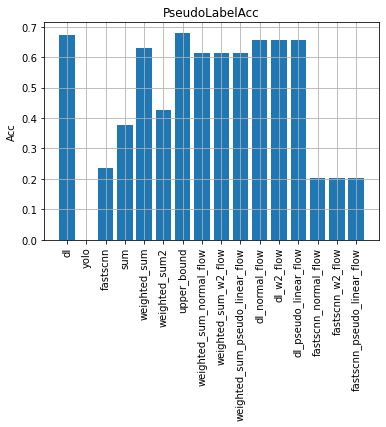

<module 'matplotlib.pyplot' from '/home/jonfrey/miniconda3/envs/track4/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [35]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

def print_acc(acc_dict, counts, counts_flow):
    avg = {}
    
    for k in acc_dict.keys():
        if k.find('flow') != -1:
            avg[k]  = acc_dict[k] / counts_flow
        else:
            avg[k] = acc_dict[k] / counts
    return avg

res = print_acc( acc_dict, counts, counts_flow)
res
x_label = [k for k in res.keys()]
data = np.array( [res[k] for k in res.keys()] )
y_label='Acc'
title = "PseudoLabelAcc"

# if type(data) == list:
#     pass
# elif type(data) == torch.Tensor:
#     data = check_shape(data)
#     data = list( data.clone().cpu())
# elif type(data) == np.ndarray:
#     data = check_shape(data)
#     data = list(data)
# else:
#     raise Exception("plot_hist: Unknown Input Type"+str(type(data)))
# data = data.tolist()
# if sort:
#     data.sort(reverse=reverse)
fig,ax = plt.subplots()
# fig,ax = plt.figure()
plt.bar(list(range(len(data))), data )
ax.set_xticks(np.arange(len(x_label)))

plt.xticks(rotation=90)
ax.set_xticklabels(x_label)
# plt.xlabel(x_label,rotation=90)
plt.ylabel(y_label)
plt.title(title)
plt.grid(True)
plt.show()
plt
# arr = get_img_from_fig(fig, dpi=300)
# plt.close()
# return np.uint8(arr)

In [27]:
x_label

['dl',
 'yolo',
 'fastscnn',
 'sum',
 'weighted_sum',
 'weighted_sum2',
 'upper_bound',
 'weighted_sum_normal_flow',
 'weighted_sum_w2_flow',
 'weighted_sum_pseudo_linear_flow',
 'dl_normal_flow',
 'dl_w2_flow',
 'dl_pseudo_linear_flow',
 'fastscnn_normal_flow',
 'fastscnn_w2_flow',
 'fastscnn_pseudo_linear_flow']

In [ ]:
ax.set_xticks(np.arange(len(label_x)))
    ax.set_yticks(np.arange(len(label_y)))
    ax.set_xticklabels(list(mappings['nyu_name_id'].keys())[:])